# Plot

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

pd.set_option('display.max_columns', None)

In [2]:
file_path = "/home/dasun/Projects/Research/ICUG/NoteBooks/data/Data.xlsx"
sheet_name = "Sheet3"

df_raw = pd.read_excel(file_path, sheet_name=sheet_name)

In [3]:
data_new = df_raw.copy()
columns_to_drop = ['Unnamed: 17','Unnamed: 18','Unnamed: 19','Unnamed: 20','Unnamed: 21','Unnamed: 22', 'Name ', 'Birth place']

data_new.drop(columns=columns_to_drop, inplace=True)

In [4]:
df_cleaned = data_new.copy()

In [5]:
df_cleaned = df_cleaned.dropna(subset=['IAUC'])

In [6]:
def extract_numerical_value(text):
    if isinstance(text, (int, float)):
        return float(text)
    if isinstance(text, str):
        try:
            return float(text)
        except ValueError:
            match = re.match(r'(\d+\.?\d*)', text)
            if match:
                return float(match.group(1))
    return np.nan

columns_to_convert = ['Carb(g/100g)', 'Protien(g)', 'Fat(g)', 'Moisture(%)', 'Ash Content', 'Dietary Fiber']
for col in columns_to_convert:
    df_cleaned[col] = df_cleaned[col].apply(extract_numerical_value)
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')


In [7]:
df_cleaned.isnull().sum()

Gender                      10
Age                         10
Weight(kg)                  10
Height(cm)                  10
BMI(kg/m2)                  10
Waist circumference         21
Hip circumference           21
WC/HC                       21
Family history diabetics    21
Physical activity           21
Health Problem              21
Alcoholic                   21
Blood Group                 21
Food Item                    0
Blood glucose                0
IAUC                         0
Carb(g/100g)                 0
Protien(g)                   0
Fat(g)                       0
Moisture(%)                 80
Ash Content                 30
Dietary Fiber               30
dtype: int64

In [8]:
columns_to_fill_zero = ['Moisture(%)', 'Ash Content', 'Dietary Fiber']
df_cleaned[columns_to_fill_zero] = df_cleaned[columns_to_fill_zero].fillna(0)
display(df_cleaned.isnull().sum())

Gender                      10
Age                         10
Weight(kg)                  10
Height(cm)                  10
BMI(kg/m2)                  10
Waist circumference         21
Hip circumference           21
WC/HC                       21
Family history diabetics    21
Physical activity           21
Health Problem              21
Alcoholic                   21
Blood Group                 21
Food Item                    0
Blood glucose                0
IAUC                         0
Carb(g/100g)                 0
Protien(g)                   0
Fat(g)                       0
Moisture(%)                  0
Ash Content                  0
Dietary Fiber                0
dtype: int64

In [9]:
numerical_cols = ['Age', 'Weight(kg)', 'Height(cm)', 'BMI(kg/m2)', 'Waist circumference', 'Hip circumference', 'WC/HC']
for col in numerical_cols:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mean())

categorical_cols_na = ['Health Problem', 'Blood Group', 'Gender']
for col in categorical_cols_na:
    df_cleaned[col] = df_cleaned[col].fillna('Not Applicable')

df_cleaned['Family history diabetics'] = df_cleaned['Family history diabetics'].fillna('No')
df_cleaned['Physical activity'] = df_cleaned['Physical activity'].fillna('Light ( Only Day-to-Day activities)')
df_cleaned['Alcoholic'] = df_cleaned['Alcoholic'].fillna('Never')

display(df_cleaned.isnull().sum())

Gender                      0
Age                         0
Weight(kg)                  0
Height(cm)                  0
BMI(kg/m2)                  0
Waist circumference         0
Hip circumference           0
WC/HC                       0
Family history diabetics    0
Physical activity           0
Health Problem              0
Alcoholic                   0
Blood Group                 0
Food Item                   0
Blood glucose               0
IAUC                        0
Carb(g/100g)                0
Protien(g)                  0
Fat(g)                      0
Moisture(%)                 0
Ash Content                 0
Dietary Fiber               0
dtype: int64

In [10]:
df_numerical = df_cleaned.select_dtypes(include=np.number)
correlation_matrix = df_numerical.corr()
display(correlation_matrix)

,Age,Weight(kg),Height(cm),BMI(kg/m2),Waist circumference,Hip circumference,WC/HC,Blood glucose,IAUC,Carb(g/100g),Protien(g),Fat(g),Moisture(%),Ash Content,Dietary Fiber
Age,1.000000,0.266551,0.224023,0.213006,0.039568,-0.065823,0.108923,0.210413,-0.142841,0.040920,0.004514,-0.029333,-0.044303,0.124966,-0.008215
Weight(kg),0.266551,1.000000,0.572444,0.796711,0.599169,0.166084,0.417989,0.303022,-0.154311,-0.055019,-0.046762,0.027641,0.074159,-0.093702,0.263052
Height(cm),0.224023,0.572444,1.000000,-0.031094,0.203620,-0.101428,0.330915,0.355756,-0.180810,-0.009688,-0.013795,0.012482,0.013133,0.022973,0.101827
BMI(kg/m2),0.213006,0.796711,-0.031094,1.000000,0.555544,0.251620,0.272418,0.106742,-0.056697,-0.054807,-0.040278,0.025301,0.073566,-0.125701,0.220324
Waist circumference,0.039568,0.599169,0.203620,0.555544,1.000000,0.654713,0.277042,-0.012150,0.082464,-0.057759,-0.046304,0.001196,0.072616,-0.074646,0.183970
Hip circumference,-0.065823,0.166084,-0.101428,0.251620,0.654713,1.000000,-0.532594,0.019319,0.013957,-0.023954,-0.004606,0.015447,0.032889,-0.066982,0.092275
WC/HC,0.108923,0.417989,0.330915,0.272418,0.277042,-0.532594,1.000000,-0.067847,0.088081,-0.043544,-0.042782,-0.019275,0.048072,-0.021731,0.053907
Blood glucose,0.210413,0.303022,0.355756,0.106742,-0.012150,0.019319,-0.067847,1.000000,-0.297815,0.103276,0.008520,-0.034742,-0.101220,0.103358,0.115406
IAUC,-0.142841,-0.154311,-0.180810,-0.056697,0.082464,0.013957,0.088081,-0.297815,1.000000,-0.471020,-0.475216,-0.375622,0.490082,-0.212886,0.079072
Carb(g/100g),0.040920,-0.055019,-0.009688,-0.054807,-0.057759,-0.023954,-0.043544,0.103276,-0.471020,1.000000,0.811972,0.593162,-0.992985,0.500830,0.220446


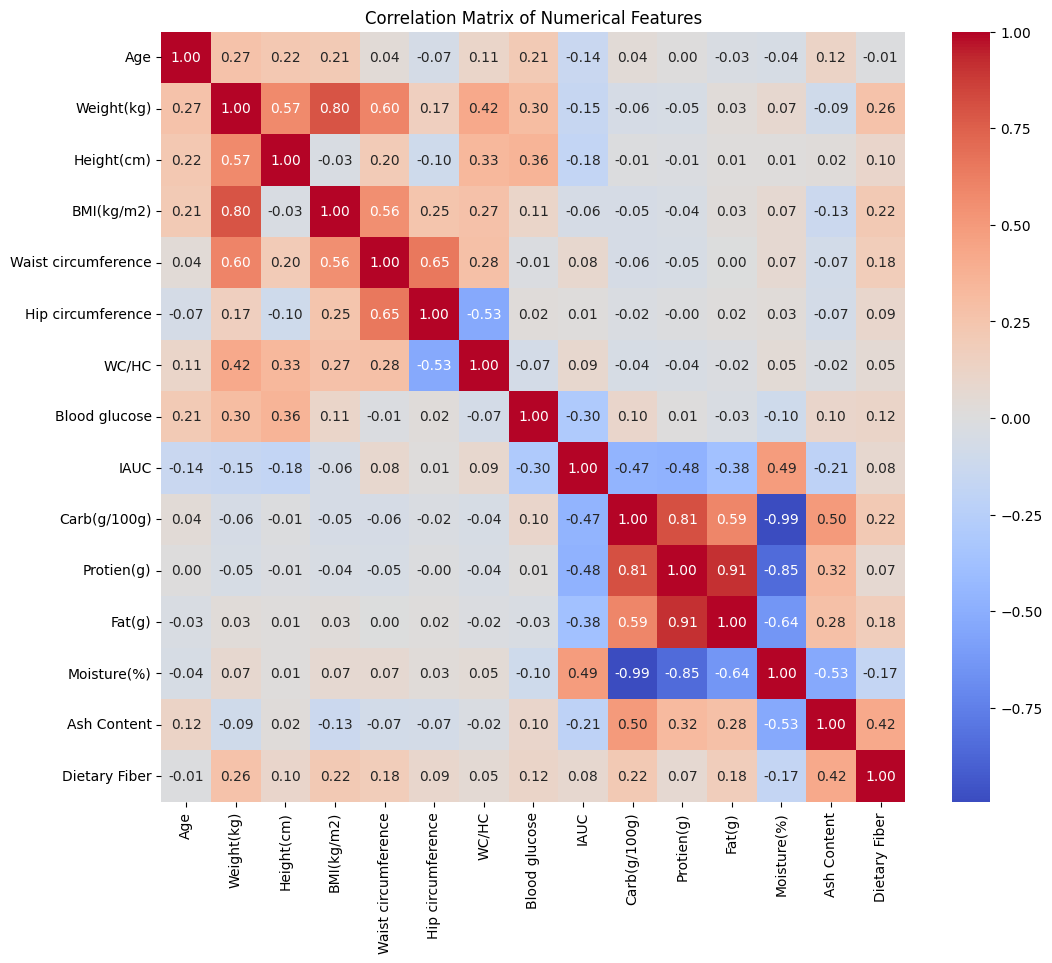

In [11]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [12]:
y = df_cleaned['IAUC']
X = df_numerical.drop('IAUC', axis=1)

selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)

feature_scores = pd.Series(selector.scores_, index=X.columns)
sorted_feature_scores = feature_scores.sort_values(ascending=False)

display(sorted_feature_scores)

Moisture(%)            36.667813
Protien(g)             33.837865
Carb(g/100g)           33.073373
Fat(g)                 19.055226
Blood glucose          11.289838
Ash Content             5.506748
Height(cm)              3.920458
Weight(kg)              2.829573
Age                     2.416109
WC/HC                   0.906987
Waist circumference     0.794234
Dietary Fiber           0.729844
BMI(kg/m2)              0.374084
Hip circumference       0.022602
dtype: float64

In [13]:
categorical_cols = df_cleaned.select_dtypes(include=['object', 'category']).columns.tolist()
print("Identified categorical columns:")
display(categorical_cols)

Identified categorical columns:


['Gender',
 'Family history diabetics',
 'Physical activity',
 'Health Problem',
 'Alcoholic',
 'Blood Group',
 'Food Item']

In [14]:
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_cols, drop_first=True)
display(df_encoded.head())

,Age,Weight(kg),Height(cm),BMI(kg/m2),Waist circumference,Hip circumference,WC/HC,Blood glucose,IAUC,Carb(g/100g),Protien(g),Fat(g),Moisture(%),Ash Content,Dietary Fiber,Gender_Male,Gender_Not Applicable,Family history diabetics_No,Family history diabetics_Yes-Father,Physical activity_Light,Physical activity_Light ( Only Day-to-Day activities),Physical activity_Moderate (Home workouts),Health Problem_No,Health Problem_Not Applicable,Alcoholic_Never,Alcoholic_Never ( I don't drink alcohol),Alcoholic_Never (I don't drink alcohol),Blood Group_AB+,Blood Group_AB-,Blood Group_B+,Blood Group_B-,Blood Group_Not Applicable,Blood Group_O+,Blood Group_O-,Food Item_Basmati-Ceylon Purple Rice,Food Item_Basmati-Red Fragrant,Food Item_Glucose Solution,Food Item_MDK String Hoppers,Food Item_Red Fragrance String Hoppers,Food Item_Rice-Red Fragrant,Food Item_Rice-Super kernal,Food Item_Sticky Basmati String Hoppers,Food Item_White Basmati String Hoppers
1,23.0,93.5,171.5,31.79,99.1,107.0,0.930000,105,2699.0,16.7,0.0,0.0,83.3,0.0,0.0,True,False,True,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,23.0,93.5,171.5,31.79,99.1,107.0,0.930000,104,1425.0,81.7,3.7,1.1,12.8,0.7,5.4,True,False,True,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3,23.0,47.7,156.8,19.40,69.7,87.0,0.800000,89,2940.0,16.7,0.0,0.0,83.3,0.0,0.0,False,False,True,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
4,23.0,47.7,156.8,19.40,69.7,87.0,0.800000,101,7208.0,79.3,4.9,1.8,12.9,1.1,5.0,False,False,True,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
114,24.0,45.0,155.0,18.70,76.2,95.0,0.802105,92,3270.0,16.7,0.0,0.0,83.3,0.0,0.0,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False


In [15]:
correlation_matrix_e = df_encoded.corr()
display(correlation_matrix_e)

,Age,Weight(kg),Height(cm),BMI(kg/m2),Waist circumference,Hip circumference,WC/HC,Blood glucose,IAUC,Carb(g/100g),Protien(g),Fat(g),Moisture(%),Ash Content,Dietary Fiber,Gender_Male,Gender_Not Applicable,Family history diabetics_No,Family history diabetics_Yes-Father,Physical activity_Light,Physical activity_Light ( Only Day-to-Day activities),Physical activity_Moderate (Home workouts),Health Problem_No,Health Problem_Not Applicable,Alcoholic_Never,Alcoholic_Never ( I don't drink alcohol),Alcoholic_Never (I don't drink alcohol),Blood Group_AB+,Blood Group_AB-,Blood Group_B+,Blood Group_B-,Blood Group_Not Applicable,Blood Group_O+,Blood Group_O-,Food Item_Basmati-Ceylon Purple Rice,Food Item_Basmati-Red Fragrant,Food Item_Glucose Solution,Food Item_MDK String Hoppers,Food Item_Red Fragrance String Hoppers,Food Item_Rice-Red Fragrant,Food Item_Rice-Super kernal,Food Item_Sticky Basmati String Hoppers,Food Item_White Basmati String Hoppers
Age,1.000000e+00,2.665509e-01,2.240229e-01,2.130059e-01,3.956815e-02,-6.582298e-02,1.089235e-01,0.210413,-0.142841,0.040920,0.004514,-0.029333,-0.044303,0.124966,-0.008215,-0.032133,-4.703535e-16,0.109160,-0.047918,0.150909,-0.321673,0.338246,0.239538,-4.515081e-01,-0.451072,0.085754,0.341766,-0.124165,0.196539,0.106809,-0.156850,-4.515081e-01,0.338369,-0.026632,-0.065499,-0.134792,-0.042230,0.047089,0.070746,-0.031709,-0.031709,0.047089,0.070746
Weight(kg),2.665509e-01,1.000000e+00,5.724443e-01,7.967113e-01,5.991685e-01,1.660840e-01,4.179888e-01,0.303022,-0.154311,-0.055019,-0.046762,0.027641,0.074159,-0.093702,0.263052,0.387647,-2.385223e-16,0.102988,-0.059512,0.014989,-0.181974,0.077413,0.214139,-1.588451e-01,0.034163,-0.159371,0.009460,0.119915,0.107369,0.076395,-0.115766,-1.588451e-01,-0.117404,-0.187088,0.062833,0.084872,0.061492,-0.087822,-0.058402,-0.041827,0.449368,-0.087822,-0.058402
Height(cm),2.240229e-01,5.724443e-01,1.000000e+00,-3.109434e-02,2.036200e-01,-1.014278e-01,3.309150e-01,0.355756,-0.180810,-0.009688,-0.013795,0.012482,0.013133,0.022973,0.101827,0.481804,1.126625e-15,0.289280,-0.248270,0.070133,-0.419529,0.320047,0.077920,-1.157836e-01,-0.049773,0.020758,-0.242905,0.008786,-0.015190,0.286017,-0.142479,-1.157836e-01,-0.300898,-0.307066,-0.010416,0.032202,0.009105,-0.027348,0.019622,-0.020722,0.151342,-0.027348,0.019622
BMI(kg/m2),2.130059e-01,7.967113e-01,-3.109434e-02,1.000000e+00,5.555441e-01,2.516204e-01,2.724185e-01,0.106742,-0.056697,-0.054807,-0.040278,0.025301,0.073566,-0.125701,0.220324,0.090154,-1.025430e-15,-0.092696,0.119202,-0.029034,0.067303,-0.110765,0.229089,-1.207447e-01,0.049168,-0.214210,0.205612,0.149688,0.154818,-0.129345,-0.043644,-1.207447e-01,0.101491,-0.003612,0.089273,0.072490,0.062308,-0.081428,-0.080372,-0.037784,0.399281,-0.081428,-0.080372
Waist circumference,3.956815e-02,5.991685e-01,2.036200e-01,5.555441e-01,1.000000e+00,6.547127e-01,2.770422e-01,-0.012150,0.082464,-0.057759,-0.046304,0.001196,0.072616,-0.074646,0.183970,0.266117,-2.038455e-15,0.137913,-0.231871,-0.133067,0.085324,-0.087276,-0.193763,-1.904385e-15,0.126289,-0.296130,0.009932,0.003561,0.172507,0.147590,0.187740,-1.904385e-15,-0.021483,-0.280419,-0.016982,0.040761,0.063818,-0.069171,-0.039047,-0.076167,0.357651,-0.069171,-0.039047
Hip circumference,-6.582298e-02,1.660840e-01,-1.014278e-01,2.516204e-01,6.547127e-01,1.000000e+00,-5.325936e-01,0.019319,0.013957,-0.023954,-0.004606,0.015447,0.032889,-0.066982,0.092275,-0.047563,-3.291115e-16,-0.167768,-0.081642,0.156400,0.247437,-0.384256,-0.174869,-8.090953e-16,0.069169,-0.109617,-0.006443,-0.118820,0.246137,0.018283,0.590832,-8.090953e-16,-0.066825,-0.109237,0.045436,-0.023340,0.028086,-0.044447,-0.037209,-0.026556,0.180727,-0.044447,-0.037209
WC/HC,1.089235e-01,4.179888e-01,3.309150e-01,2.724185e-01,2.770422e-01,-5.325936e-01,1.000000e+00,-0.067847,0.088081,-0.043544,-0.042782,-0.019275,0.048072,-0.021731,0.053907,0.340212,-9.576627e-16,0.329276,-0.169949,-0.343767,-0.275222,0.458796,0.022503,-6.746789e-16,0.034091,-0.221597,0.

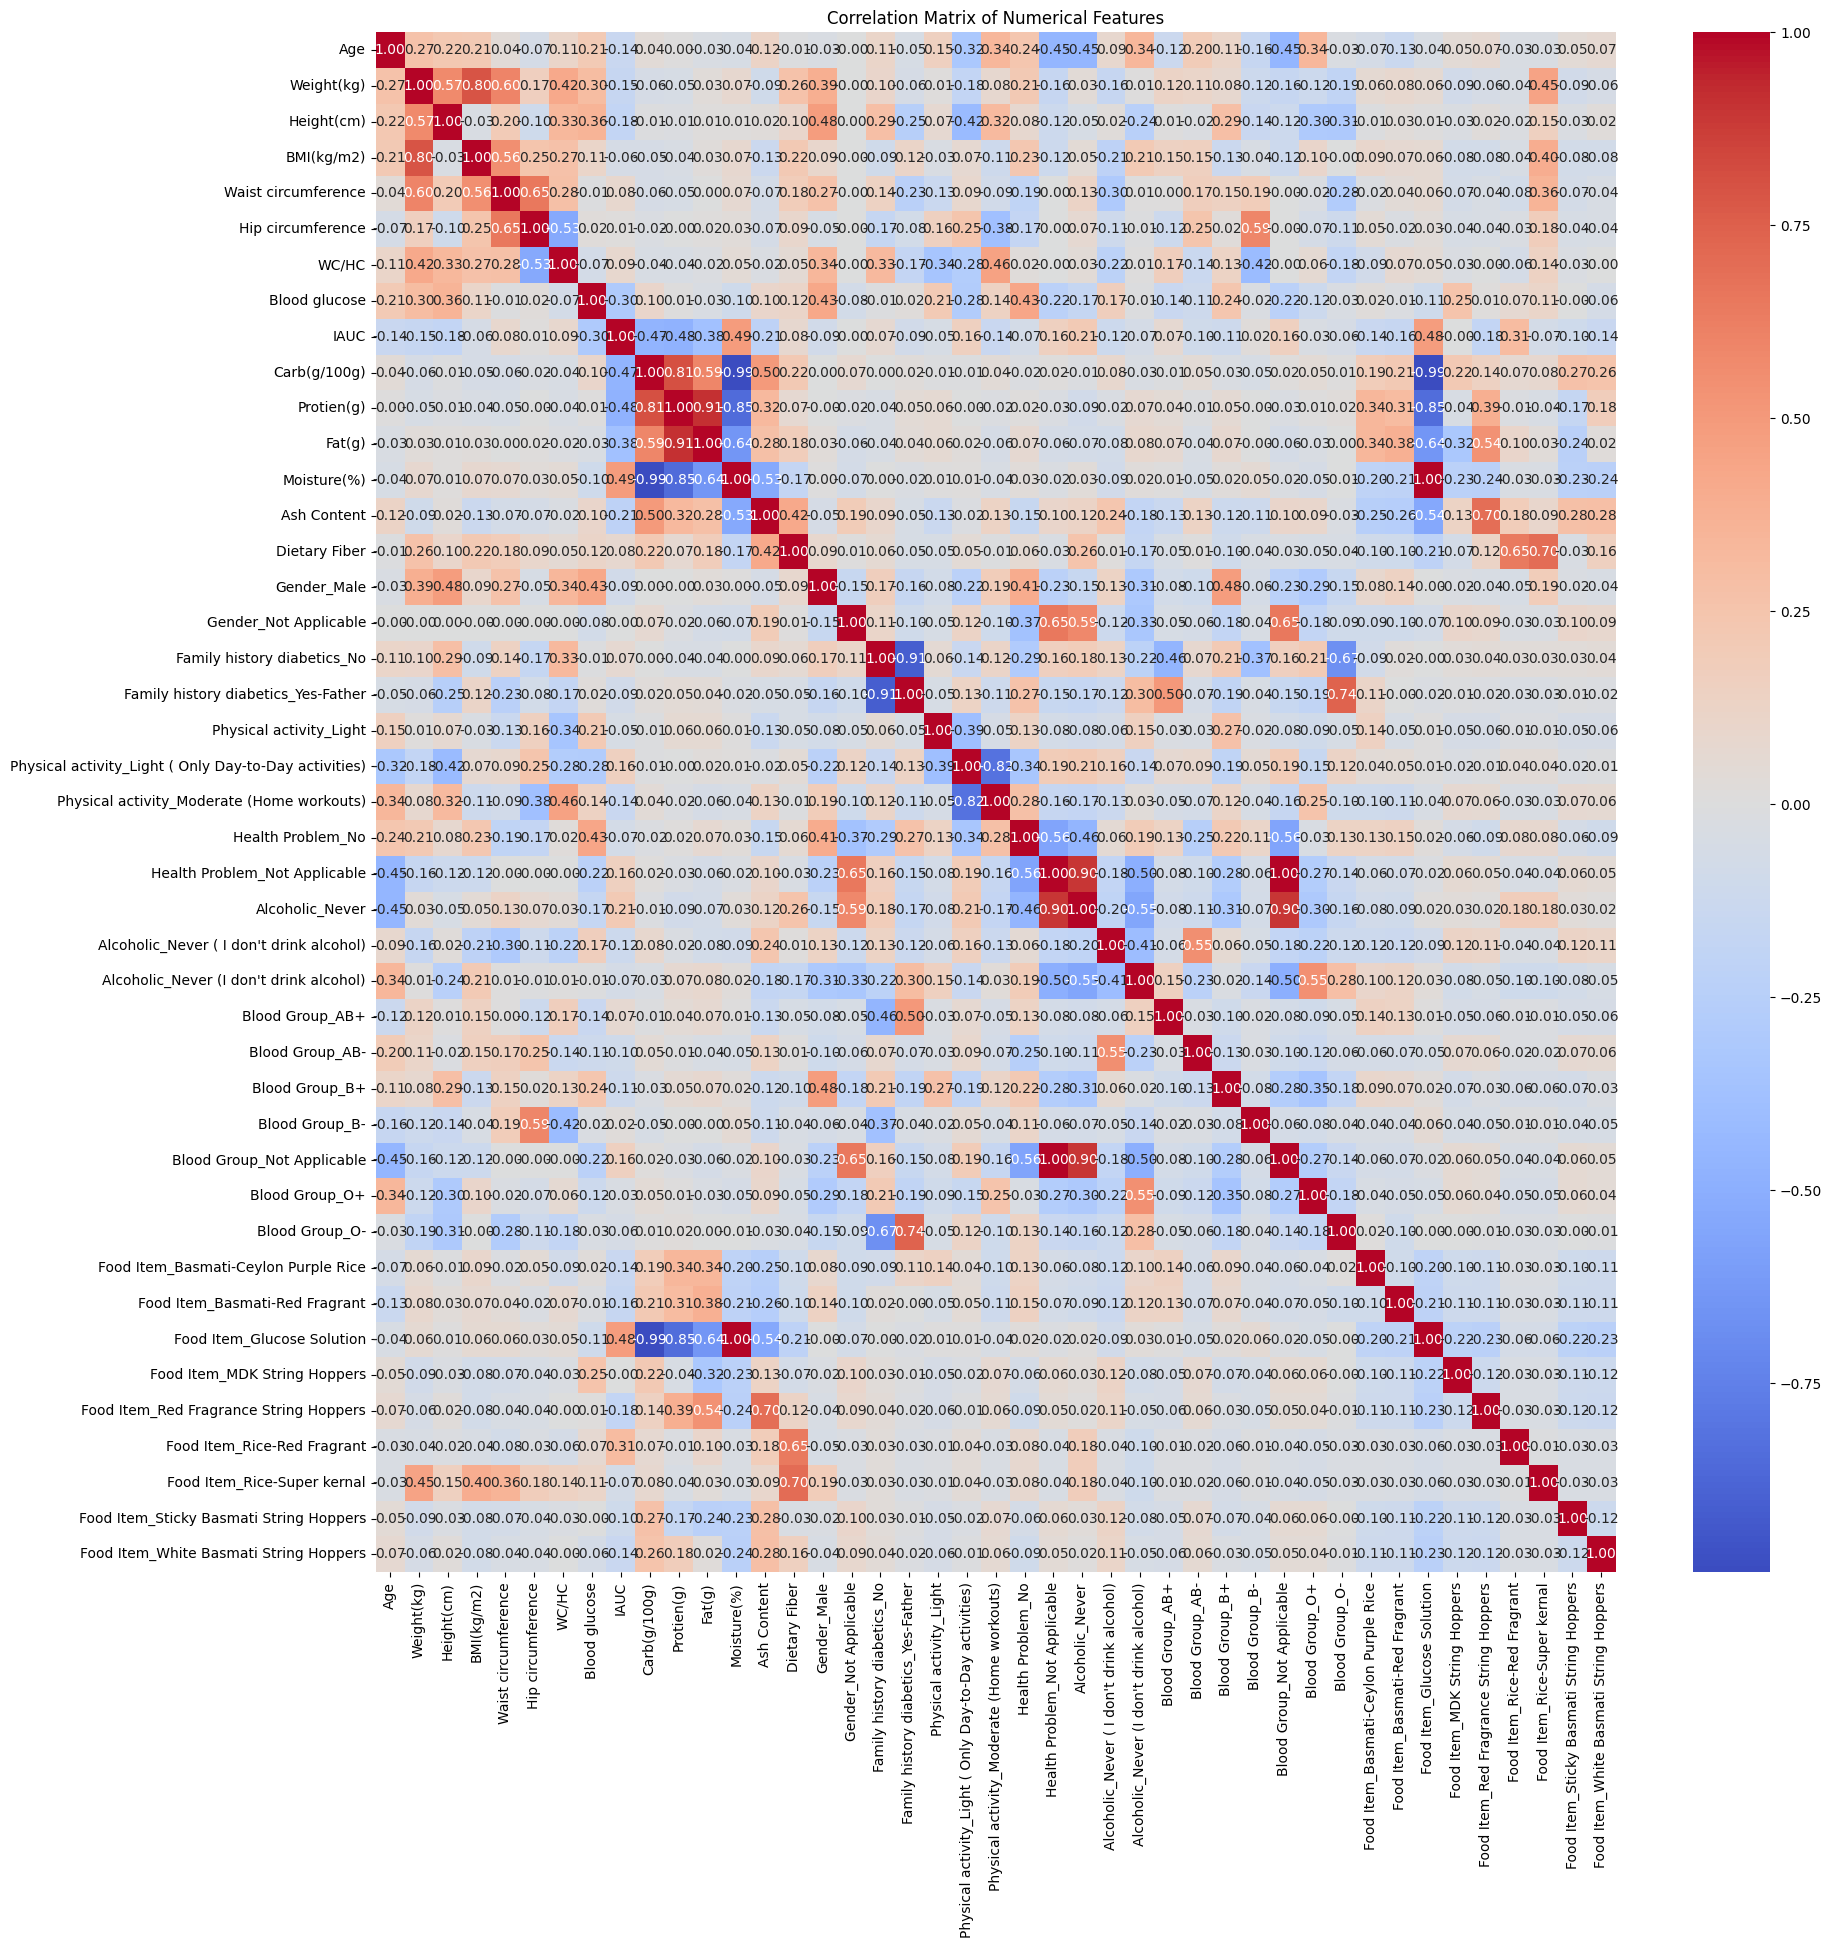

In [16]:
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix_e, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [17]:
y_e = df_encoded['IAUC']
X_e = df_encoded.drop('IAUC', axis=1)

selector_e = SelectKBest(score_func=f_regression, k='all')
selector_e.fit(X_e, y_e)

feature_scores_e = pd.Series(selector_e.scores_, index=X_e.columns)
sorted_feature_scores_e = feature_scores_e.sort_values(ascending=False)

display(sorted_feature_scores_e)

Moisture(%)                                              36.667813
Food Item_Glucose Solution                               34.972837
Protien(g)                                               33.837865
Carb(g/100g)                                             33.073373
Fat(g)                                                   19.055226
Food Item_Rice-Red Fragrant                              12.319890
Blood glucose                                            11.289838
Ash Content                                               5.506748
Alcoholic_Never                                           5.283240
Height(cm)                                                3.920458
Food Item_Red Fragrance String Hoppers                    3.902182
Food Item_Basmati-Red Fragrant                            3.034108
Physical activity_Light ( Only Day-to-Day activities)     2.939997
Health Problem_Not Applicable                             2.873863
Blood Group_Not Applicable                                2.87

In [18]:
y_reduced = df_encoded['IAUC']
X_reduced = df_encoded.drop('IAUC', axis=1)

X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=42)

print("Shape of X_train_reduced:", X_train_reduced.shape)
print("Shape of X_test_reduced:", X_test_reduced.shape)
print("Shape of y_train_reduced:", y_train_reduced.shape)
print("Shape of y_test_reduced:", y_test_reduced.shape)

Shape of X_train_reduced: (94, 42)
Shape of X_test_reduced: (24, 42)
Shape of y_train_reduced: (94,)
Shape of y_test_reduced: (24,)


In [19]:
rf_reduced_model = RandomForestRegressor(random_state=42)
rf_reduced_model.fit(X_train_reduced, y_train_reduced)
display(rf_reduced_model)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
y_pred_rf_reduced = rf_reduced_model.predict(X_test_reduced)

mse_rf_reduced = mean_squared_error(y_test_reduced, y_pred_rf_reduced)
r2_rf_reduced = r2_score(y_test_reduced, y_pred_rf_reduced)

print(f"Random Forest Model with Reduced Features Test Mean Squared Error: {mse_rf_reduced:.2f}")
print(f"Random Forest Model with Reduced Features Test R-squared Score: {r2_rf_reduced:.2f}")

Random Forest Model with Reduced Features Test Mean Squared Error: 1807270.09
Random Forest Model with Reduced Features Test R-squared Score: 0.19


In [21]:
param_grid_rf_combined = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [22]:
rf_combined_model = RandomForestRegressor(random_state=42)

grid_search_rf_combined = GridSearchCV(estimator=rf_combined_model, param_grid=param_grid_rf_combined, cv=5)
grid_search_rf_combined.fit(X_train_reduced, y_train_reduced)

,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [23]:
best_params_rf_combined = grid_search_rf_combined.best_params_
best_rf_model_combined = RandomForestRegressor(random_state=42, **best_params_rf_combined)
best_rf_model_combined.fit(X_train_reduced, y_train_reduced)
display(best_rf_model_combined)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,10
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [24]:
y_pred_rf_combined_tuned = best_rf_model_combined.predict(X_test_reduced)

mse_rf_combined_tuned = mean_squared_error(y_test_reduced, y_pred_rf_combined_tuned)
r2_rf_combined_tuned = r2_score(y_test_reduced, y_pred_rf_combined_tuned)

print(f"Tuned Random Forest Model with Combined Features Mean Squared Error: {mse_rf_combined_tuned:.2f}")
print(f"Tuned Random Forest Model with Combined Features R-squared Score: {r2_rf_combined_tuned:.2f}")

Tuned Random Forest Model with Combined Features Mean Squared Error: 1807144.90
Tuned Random Forest Model with Combined Features R-squared Score: 0.19


In [25]:
lgbm_combined_model = LGBMRegressor(random_state=42)
lgbm_combined_model.fit(X_train_reduced, y_train_reduced)
display(lgbm_combined_model)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 94, number of used features: 19
[LightGBM] [Info] Start training from score 2488.564152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [26]:
y_pred_combined = lgbm_combined_model.predict(X_test_reduced)

mse_lgbm_combined = mean_squared_error(y_test_reduced, y_pred_combined)
r2_lgbm_combined = r2_score(y_test_reduced, y_pred_combined)

print(f"LightGBM Model with Combined Features Mean Squared Error: {mse_lgbm_combined:.2f}")
print(f"LightGBM Model with Combined Features R-squared Score: {r2_lgbm_combined:.2f}")

LightGBM Model with Combined Features Mean Squared Error: 1697661.00
LightGBM Model with Combined Features R-squared Score: 0.24


In [27]:
display(sorted_feature_scores_e)

# Let's select features with a score greater than a certain threshold, e.g., 1.0
selected_features = sorted_feature_scores_e[sorted_feature_scores_e > 1.0].index.tolist()

X_selected = df_encoded[selected_features]
y_selected = df_encoded['IAUC']

print("\nSelected Features:")
display(selected_features)
print("\nShape of X_selected:", X_selected.shape)
print("Shape of y_selected:", y_selected.shape)

Moisture(%)                                              36.667813
Food Item_Glucose Solution                               34.972837
Protien(g)                                               33.837865
Carb(g/100g)                                             33.073373
Fat(g)                                                   19.055226
Food Item_Rice-Red Fragrant                              12.319890
Blood glucose                                            11.289838
Ash Content                                               5.506748
Alcoholic_Never                                           5.283240
Height(cm)                                                3.920458
Food Item_Red Fragrance String Hoppers                    3.902182
Food Item_Basmati-Red Fragrant                            3.034108
Physical activity_Light ( Only Day-to-Day activities)     2.939997
Health Problem_Not Applicable                             2.873863
Blood Group_Not Applicable                                2.87


Selected Features:


['Moisture(%)',
 'Food Item_Glucose Solution',
 'Protien(g)',
 'Carb(g/100g)',
 'Fat(g)',
 'Food Item_Rice-Red Fragrant',
 'Blood glucose',
 'Ash Content',
 'Alcoholic_Never',
 'Height(cm)',
 'Food Item_Red Fragrance String Hoppers',
 'Food Item_Basmati-Red Fragrant',
 'Physical activity_Light ( Only Day-to-Day activities)',
 'Health Problem_Not Applicable',
 'Blood Group_Not Applicable',
 'Weight(kg)',
 'Food Item_Basmati-Ceylon Purple Rice',
 'Age',
 'Food Item_White Basmati String Hoppers',
 'Physical activity_Moderate (Home workouts)',
 "Alcoholic_Never ( I don't drink alcohol)",
 'Blood Group_B+',
 'Food Item_Sticky Basmati String Hoppers',
 'Blood Group_AB-']


Shape of X_selected: (118, 24)
Shape of y_selected: (118,)


In [28]:
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(
    X_selected, y_selected, test_size=0.2, random_state=42
)

print("Shape of X_train_selected:", X_train_selected.shape)
print("Shape of X_test_selected:", X_test_selected.shape)
print("Shape of y_train_selected:", y_train_selected.shape)
print("Shape of y_test_selected:", y_test_selected.shape)

Shape of X_train_selected: (94, 24)
Shape of X_test_selected: (24, 24)
Shape of y_train_selected: (94,)
Shape of y_test_selected: (24,)


In [29]:
rf_selected_model = RandomForestRegressor(random_state=42)
rf_selected_model.fit(X_train_selected, y_train_selected)

y_pred_rf_selected = rf_selected_model.predict(X_test_selected)

mse_rf_selected = mean_squared_error(y_test_selected, y_pred_rf_selected)
r2_rf_selected = r2_score(y_test_selected, y_pred_rf_selected)

print(f"Random Forest Model with Selected Features Test Mean Squared Error: {mse_rf_selected:.2f}")
print(f"Random Forest Model with Selected Features Test R-squared Score: {r2_rf_selected:.2f}")

Random Forest Model with Selected Features Test Mean Squared Error: 1752009.94
Random Forest Model with Selected Features Test R-squared Score: 0.22


In [30]:
print(f"Random Forest Model with Reduced Features Test Mean Squared Error: {mse_rf_reduced:.2f}")
print(f"Random Forest Model with Reduced Features Test R-squared Score: {r2_rf_reduced:.2f}")
print(f"Random Forest Model with Selected Features Test Mean Squared Error: {mse_rf_selected:.2f}")
print(f"Random Forest Model with Selected Features Test R-squared Score: {r2_rf_selected:.2f}")
print(f"Tuned Random Forest Model with Combined Features Mean Squared Error: {mse_rf_combined_tuned:.2f}")
print(f"Tuned Random Forest Model with Combined Features R-squared Score: {r2_rf_combined_tuned:.2f}")
print(f"LightGBM Model with Combined Features Mean Squared Error: {mse_lgbm_combined:.2f}")
print(f"LightGBM Model with Combined Features R-squared Score: {r2_lgbm_combined:.2f}")

Random Forest Model with Reduced Features Test Mean Squared Error: 1807270.09
Random Forest Model with Reduced Features Test R-squared Score: 0.19
Random Forest Model with Selected Features Test Mean Squared Error: 1752009.94
Random Forest Model with Selected Features Test R-squared Score: 0.22
Tuned Random Forest Model with Combined Features Mean Squared Error: 1807144.90
Tuned Random Forest Model with Combined Features R-squared Score: 0.19
LightGBM Model with Combined Features Mean Squared Error: 1697661.00
LightGBM Model with Combined Features R-squared Score: 0.24
